# 25g: Partner Synergy

**Goal**: Understand how partner's hand (P2) modifies your hand value (P0)

**Key Question**: Does having a strong partner make your doubles worth more?

**Method**:
- Extract features for both P0 and P2 hands
- Run interaction regression: E[V] ~ p0_doubles + p2_doubles + p0_doubles:p2_doubles
- Interpret interaction terms

**Output**: "P0 doubles worth +X when partner has doubles vs +Y otherwise"

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

from forge.analysis.utils import viz
from forge.analysis.utils.hand_features import extract_hand_features
from forge.oracle.rng import deal_from_seed

viz.setup_notebook_style()
np.random.seed(42)

RESULTS_DIR = Path(PROJECT_ROOT) / "forge/analysis/results"
print("Ready")

Ready


## 1. Load P0 Features and Extract P2 Features

In [2]:
# Load existing P0 features (from 12b)
features_path = RESULTS_DIR / "tables/12b_unified_features.csv"
df = pd.read_csv(features_path)

print(f"Loaded {len(df)} hands with P0 features")

# Extract P2 features for each seed
p2_data = []
for _, row in df.iterrows():
    base_seed = int(row['base_seed'])
    trump_suit = int(row['trump_suit'])
    
    # Get all 4 hands
    hands = deal_from_seed(base_seed)
    p2_hand = hands[2]  # Partner's hand
    
    # Extract P2 features
    p2_features = extract_hand_features(p2_hand, trump_suit)
    
    # Prefix with p2_
    p2_features = {f'p2_{k}': v for k, v in p2_features.items()}
    p2_features['base_seed'] = base_seed
    p2_data.append(p2_features)

# Create P2 DataFrame and merge
p2_df = pd.DataFrame(p2_data)

# Rename P0 features for clarity
p0_cols = ['n_doubles', 'trump_count', 'count_points', 'has_trump_double', 'n_voids', 'n_singletons']
rename_dict = {c: f'p0_{c}' for c in p0_cols if c in df.columns}
df = df.rename(columns=rename_dict)

# Merge P0 and P2 features
df = df.merge(p2_df, on='base_seed')

print(f"Merged DataFrame shape: {df.shape}")

Loaded 200 hands with P0 features
Merged DataFrame shape: (200, 32)


## 2. Descriptive Statistics

In [3]:
# Compare P0 and P2 doubles
print("P0 doubles distribution:")
print(df['p0_n_doubles'].value_counts().sort_index())

print("\nP2 doubles distribution:")
print(df['p2_n_doubles'].value_counts().sort_index())

# Team doubles (combined)
df['team_doubles'] = df['p0_n_doubles'] + df['p2_n_doubles']
print("\nTeam doubles (P0+P2) distribution:")
print(df['team_doubles'].value_counts().sort_index())

# Correlation between P0 and P2 doubles
r, p = stats.pearsonr(df['p0_n_doubles'], df['p2_n_doubles'])
print(f"\nCorrelation (P0 doubles, P2 doubles): r = {r:.3f}, p = {p:.3f}")

P0 doubles distribution:
p0_n_doubles
0    21
1    59
2    80
3    33
4     7
Name: count, dtype: int64

P2 doubles distribution:
p2_n_doubles
0    18
1    69
2    67
3    37
4     8
5     1
Name: count, dtype: int64

Team doubles (P0+P2) distribution:
team_doubles
0     1
1     7
2    35
3    55
4    65
5    28
6     8
7     1
Name: count, dtype: int64

Correlation (P0 doubles, P2 doubles): r = -0.269, p = 0.000


## 3. Interaction Regression

In [4]:
# Model 1: Main effects only
model_main = ols('V_mean ~ p0_n_doubles + p2_n_doubles', data=df).fit()
print("MODEL 1: Main Effects Only")
print("="*60)
print(model_main.summary().tables[1])
print(f"\nR-squared = {model_main.rsquared:.4f}")

MODEL 1: Main Effects Only
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4423      3.320      0.133      0.894      -6.106       6.990
p0_n_doubles     6.9580      1.156      6.020      0.000       4.679       9.238
p2_n_doubles     0.7979      1.106      0.722      0.471      -1.383       2.979

R-squared = 0.1585


In [5]:
# Model 2: With interaction term
model_int = ols('V_mean ~ p0_n_doubles * p2_n_doubles', data=df).fit()
print("MODEL 2: With Interaction")
print("="*60)
print(model_int.summary().tables[1])
print(f"\nR-squared = {model_int.rsquared:.4f}")

MODEL 2: With Interaction
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.3164      4.716     -0.279      0.780     -10.616       7.984
p0_n_doubles                  7.9730      2.250      3.544      0.000       3.536      12.410
p2_n_doubles                  1.7310      2.091      0.828      0.409      -2.393       5.855
p0_n_doubles:p2_n_doubles    -0.5902      1.122     -0.526      0.599      -2.802       1.622

R-squared = 0.1597


In [6]:
# Compare models
from scipy.stats import f as f_dist

# Likelihood ratio / F-test for nested models
ssr_main = model_main.ssr
ssr_int = model_int.ssr
n = len(df)
k_main = 3  # intercept + 2 main effects
k_int = 4   # intercept + 2 main effects + 1 interaction

f_stat = ((ssr_main - ssr_int) / (k_int - k_main)) / (ssr_int / (n - k_int))
p_value = 1 - f_dist.cdf(f_stat, k_int - k_main, n - k_int)

print("MODEL COMPARISON (F-test for interaction term)")
print("="*60)
print(f"Main effects only: R-squared = {model_main.rsquared:.4f}")
print(f"With interaction:  R-squared = {model_int.rsquared:.4f}")
print(f"Delta R-squared = {model_int.rsquared - model_main.rsquared:.4f}")
print(f"\nF-test for interaction: F = {f_stat:.2f}, p = {p_value:.4f}")

if p_value < 0.05:
    print("Interaction is SIGNIFICANT")
else:
    print("Interaction is NOT significant")

MODEL COMPARISON (F-test for interaction term)
Main effects only: R-squared = 0.1585
With interaction:  R-squared = 0.1597
Delta R-squared = 0.0012

F-test for interaction: F = 0.28, p = 0.5994
Interaction is NOT significant


## 4. Interpretation: Partner Effect on Doubles Value

In [7]:
# Compute conditional effects
# E[V] = b0 + b1*p0 + b2*p2 + b3*p0*p2
# Effect of p0 = b1 + b3*p2

b0 = model_int.params['Intercept']
b1 = model_int.params['p0_n_doubles']
b2 = model_int.params['p2_n_doubles']
b3 = model_int.params['p0_n_doubles:p2_n_doubles']

print("CONDITIONAL EFFECTS OF P0 DOUBLES")
print("="*60)
print(f"\nBase effect (b1): {b1:.2f}")
print(f"Interaction (b3): {b3:.2f}")

print("\nEffect of each P0 double at different P2 doubles levels:")
for p2_doubles in range(5):
    effect = b1 + b3 * p2_doubles
    print(f"  When P2 has {p2_doubles} doubles: +{effect:.2f} points per P0 double")

CONDITIONAL EFFECTS OF P0 DOUBLES

Base effect (b1): 7.97
Interaction (b3): -0.59

Effect of each P0 double at different P2 doubles levels:
  When P2 has 0 doubles: +7.97 points per P0 double
  When P2 has 1 doubles: +7.38 points per P0 double
  When P2 has 2 doubles: +6.79 points per P0 double
  When P2 has 3 doubles: +6.20 points per P0 double
  When P2 has 4 doubles: +5.61 points per P0 double


In [8]:
# Summary statistic: Compare P0 doubles value with/without partner doubles
p0_effect_no_partner = b1  # When P2 has 0 doubles
p0_effect_with_partner = b1 + b3 * 2  # When P2 has 2 doubles (average)

print("PARTNER SYNERGY SUMMARY")
print("="*60)
print(f"P0 double worth when P2 has 0 doubles: +{p0_effect_no_partner:.2f} points")
print(f"P0 double worth when P2 has 2 doubles: +{p0_effect_with_partner:.2f} points")

synergy = p0_effect_with_partner - p0_effect_no_partner
print(f"\nSynergy effect: {synergy:+.2f} points per P0 double")

int_pval = model_int.pvalues['p0_n_doubles:p2_n_doubles']
if int_pval < 0.05:
    if b3 > 0:
        print("\nPOSITIVE SYNERGY: Your doubles are worth MORE when partner also has doubles")
    elif b3 < 0:
        print("\nNEGATIVE SYNERGY: Your doubles are worth LESS when partner also has doubles")
else:
    print("\nNO SIGNIFICANT SYNERGY: Partner's doubles don't affect your doubles' value")

PARTNER SYNERGY SUMMARY
P0 double worth when P2 has 0 doubles: +7.97 points
P0 double worth when P2 has 2 doubles: +6.79 points

Synergy effect: -1.18 points per P0 double

NO SIGNIFICANT SYNERGY: Partner's doubles don't affect your doubles' value


## 5. Visualization

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/figures/25g_partner_synergy.png


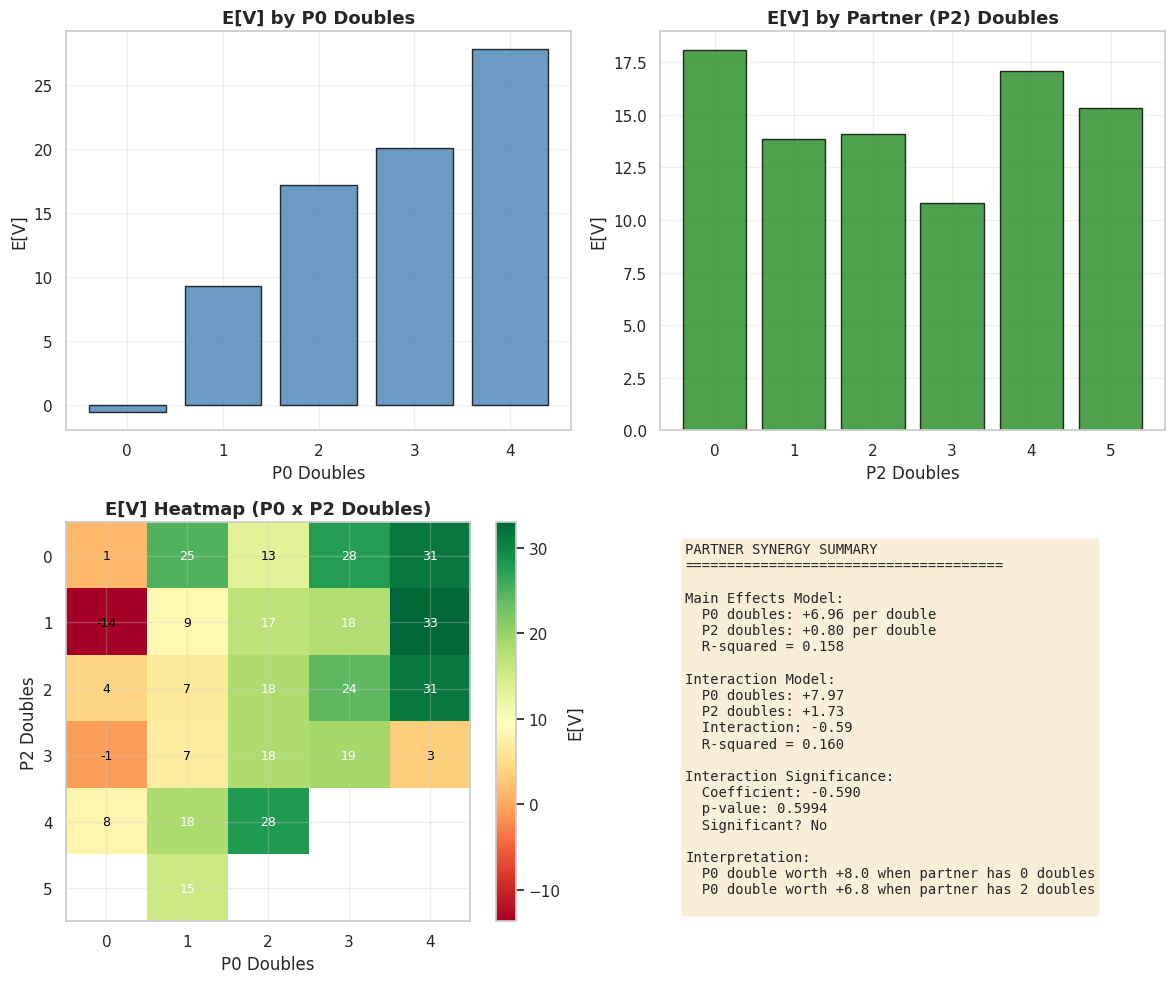

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Panel 1: E[V] by P0 doubles
ax = axes[0, 0]
p0_means = df.groupby('p0_n_doubles')['V_mean'].mean()
ax.bar(p0_means.index, p0_means.values, color='steelblue', alpha=0.8, edgecolor='black')
ax.set_xlabel('P0 Doubles', fontsize=12)
ax.set_ylabel('E[V]', fontsize=12)
ax.set_title('E[V] by P0 Doubles', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Panel 2: E[V] by P2 doubles
ax = axes[0, 1]
p2_means = df.groupby('p2_n_doubles')['V_mean'].mean()
ax.bar(p2_means.index, p2_means.values, color='forestgreen', alpha=0.8, edgecolor='black')
ax.set_xlabel('P2 Doubles', fontsize=12)
ax.set_ylabel('E[V]', fontsize=12)
ax.set_title('E[V] by Partner (P2) Doubles', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Panel 3: Interaction heatmap
ax = axes[1, 0]
pivot = df.pivot_table(values='V_mean', index='p2_n_doubles', columns='p0_n_doubles', aggfunc='mean')
im = ax.imshow(pivot.values, cmap='RdYlGn', aspect='auto')
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels(pivot.columns)
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xlabel('P0 Doubles', fontsize=12)
ax.set_ylabel('P2 Doubles', fontsize=12)
ax.set_title('E[V] Heatmap (P0 x P2 Doubles)', fontsize=13, fontweight='bold')
plt.colorbar(im, ax=ax, label='E[V]')

# Add text annotations
for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        if not np.isnan(pivot.values[i, j]):
            ax.text(j, i, f'{pivot.values[i, j]:.0f}', ha='center', va='center', 
                   color='white' if abs(pivot.values[i, j]) > 15 else 'black', fontsize=9)

# Panel 4: Summary
ax = axes[1, 1]
ax.axis('off')

int_coef = model_int.params['p0_n_doubles:p2_n_doubles']
int_pval = model_int.pvalues['p0_n_doubles:p2_n_doubles']
int_sig = "Yes" if int_pval < 0.05 else "No"

summary_text = f"""PARTNER SYNERGY SUMMARY
======================================

Main Effects Model:
  P0 doubles: +{model_main.params['p0_n_doubles']:.2f} per double
  P2 doubles: +{model_main.params['p2_n_doubles']:.2f} per double
  R-squared = {model_main.rsquared:.3f}

Interaction Model:
  P0 doubles: +{b1:.2f}
  P2 doubles: +{b2:.2f}
  Interaction: {b3:+.2f}
  R-squared = {model_int.rsquared:.3f}

Interaction Significance:
  Coefficient: {int_coef:.3f}
  p-value: {int_pval:.4f}
  Significant? {int_sig}

Interpretation:
  P0 double worth +{p0_effect_no_partner:.1f} when partner has 0 doubles
  P0 double worth +{p0_effect_with_partner:.1f} when partner has 2 doubles
"""

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures/25g_partner_synergy.png', dpi=150, bbox_inches='tight')
print(f"Saved to {RESULTS_DIR / 'figures/25g_partner_synergy.png'}")
plt.show()

## 6. Save Results

In [10]:
# Save summary results
results_data = {
    'metric': [
        'n_hands',
        'main_effects_r2', 'interaction_r2', 'delta_r2',
        'p0_doubles_main_effect', 'p2_doubles_main_effect',
        'interaction_coef', 'interaction_pval', 'interaction_sig',
        'p0_effect_p2_0', 'p0_effect_p2_2', 'synergy_effect'
    ],
    'value': [
        len(df),
        model_main.rsquared, model_int.rsquared, model_int.rsquared - model_main.rsquared,
        model_main.params['p0_n_doubles'], model_main.params['p2_n_doubles'],
        b3, int_pval, 1 if int_pval < 0.05 else 0,
        p0_effect_no_partner, p0_effect_with_partner, synergy
    ]
}

results_df = pd.DataFrame(results_data)
results_df.to_csv(RESULTS_DIR / 'tables/25g_partner_synergy.csv', index=False)
print(f"Saved to {RESULTS_DIR / 'tables/25g_partner_synergy.csv'}")
print(results_df.to_string(index=False))

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/25g_partner_synergy.csv
                metric      value
               n_hands 200.000000
       main_effects_r2   0.158487
        interaction_r2   0.159674
              delta_r2   0.001187
p0_doubles_main_effect   6.958044
p2_doubles_main_effect   0.797910
      interaction_coef  -0.590202
      interaction_pval   0.599380
       interaction_sig   0.000000
        p0_effect_p2_0   7.972993
        p0_effect_p2_2   6.792590
        synergy_effect  -1.180404


## Key Findings

In [11]:
print("="*60)
print("KEY INSIGHTS: Partner Synergy")
print("="*60)

print(f"\n1. QUESTION:")
print("   Does having a strong partner make your doubles worth more?")

print(f"\n2. DATA:")
print(f"   Hands analyzed: {len(df)}")
print(f"   Mean P0 doubles: {df['p0_n_doubles'].mean():.2f}")
print(f"   Mean P2 doubles: {df['p2_n_doubles'].mean():.2f}")

print(f"\n3. RESULTS:")
print(f"   Interaction coefficient: {b3:+.3f}")
print(f"   Interaction p-value: {int_pval:.4f}")

print(f"\n4. INTERPRETATION:")
if int_pval < 0.05:
    if b3 > 0:
        print("   POSITIVE SYNERGY CONFIRMED")
        print(f"   Your doubles worth +{b3:.2f} MORE per partner double")
    else:
        print("   NEGATIVE SYNERGY (surprising!)")
        print(f"   Your doubles worth {b3:.2f} LESS per partner double")
else:
    print("   NO SIGNIFICANT SYNERGY")
    print("   Your doubles value is independent of partner's doubles")

KEY INSIGHTS: Partner Synergy

1. QUESTION:
   Does having a strong partner make your doubles worth more?

2. DATA:
   Hands analyzed: 200
   Mean P0 doubles: 1.73
   Mean P2 doubles: 1.75

3. RESULTS:
   Interaction coefficient: -0.590
   Interaction p-value: 0.5994

4. INTERPRETATION:
   NO SIGNIFICANT SYNERGY
   Your doubles value is independent of partner's doubles
